$$\mathbf{Chad \ \ Schupbach}$$

***

The default backend engine for Keras (Tensorflow) uses CUDA, an API only supported by NVIDIA GPUs. We utilize [PlaidML](https://github.com/plaidml/plaidml) as Keras backend engine, which has Metal support for the current device GPU (AMD Radeon Pro 5300M). We reassign Keras backend engine as PlaidML in the following two code blocks.

In [1]:
import os

In [2]:
path = '/Users/chadschupbach/opt/anaconda3/'
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
os.environ['RUNFILES_DIR'] = path + 'share/plaidml'
os.environ['PLAIDML_NATIVE_PATH'] = path + 'lib/libplaidml.dylib'

In [3]:
import numpy as np
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import time
from src import utils

Using plaidml.keras.backend backend.


# Fashion MNIST

With advancements in deep learning over the past several years, the MNIST digits classification problem is no longer difficult. Prior to these advancements, support-vector machine classification was considered to be the optimal approach to the MNIST digits problem; achieving a maximum testing accuracy around 97.8% [[Zalando Research](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/#)]. The leap in performance with deep learning techniques can be seen in our previous [notebook](https://nbviewer.jupyter.org/github/cschupbach/deep_learning_cnn/blob/master/digits_ensemble.ipynb), where we used an ensemble CNN to achieve a testing accuracy of 99.67%.

The [MNIST fashion](https://github.com/zalandoresearch/fashion-mnist) dataset was released in 2017 to serve as a direct replacement to the original MNIST digits dataset. This is primarily due to the MNIST fashion classification problem being more difficult than its predecessor. As a benchmark, support-vector machine classifiers have performed best of all shallow learning algorithms with testing accuracies up to 89.7% [[Zalando Research](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/#)]. Like the MNIST digits dataset, the fashion dataset is part of the Keras distribution. Therefore, it does not need to be downloaded elsewhere. The dataset also has the same dimensions as the MNIST digits dataset; meaning training a deep learning algorithm doesn't necessarily require using a GPU.

## Initialization

Load the entire MNIST fashion dataset containing 60000 training images and 10000 testing images across 10 classes.

In [4]:
x_train, y_train, x_test, y_test, input_shape = utils.load_mnist(
    dataset='fashion'
)

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


The first 12 samples from each class are shown below.

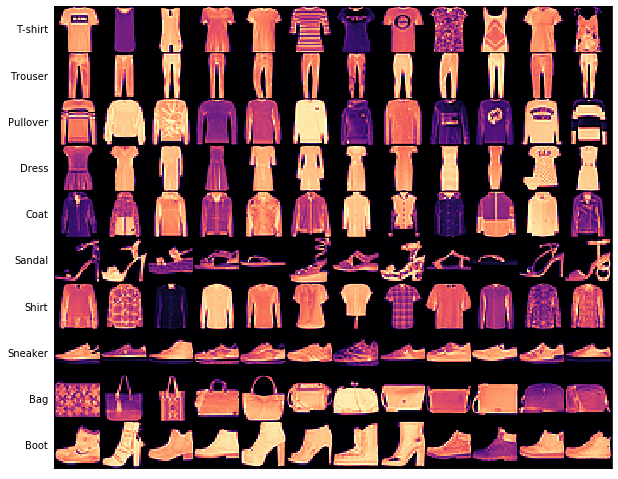

In [5]:
utils.plot_samples(x_train, y_train, dataset='fashion')

We display the mean training image for each class as follows:

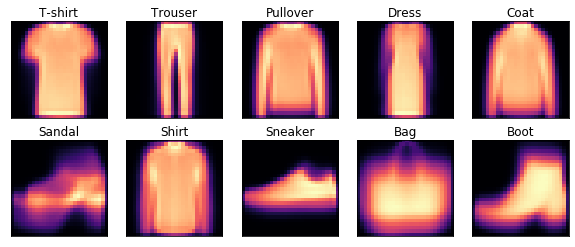

In [6]:
utils.plot_class_means(x_train, y_train, dataset='fashion')

For the ensemble CNN, we will train 10 models with the same architecture using a batch size of 128.

In [7]:
n_classes = y_test.shape[-1]
n_models = 10
batch_size = 128

The architecture of each CNN model is as follows:

In [8]:
model = [None] * n_models
for i in range(n_models):
    model[i] = Sequential()
    model[i].add(Conv2D(16, 3, padding='same', activation='relu',
                        input_shape=(28, 28, 1)))
    model[i].add(Conv2D(16, 3, padding='same', activation='relu'))
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(32, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(32, 3, padding='same', activation='relu'))
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(64, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(64, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(64, 3, activation='relu'))
    model[i].add(Flatten())
    model[i].add(Dropout(0.25))
    model[i].add(Dense(batch_size, activation='relu'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(batch_size, activation='relu'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(n_classes, activation='softmax'))
    model[i].compile(optimizer='nadam', loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [9]:
model[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
__________

We assign model checkpoints and early stopping criterion below. The checkpoints save parameter weights of the best training epoch based on validation accuracy to files in the `models/fashion/` directory. We also set early stopping criterion indicating convergence when no decrease in validation loss is observed over 10 epochs.

In [10]:
fp = 'models/fashion/'
checkpoint = []
earlystop = []
for i in range(n_models):
    checkpoint += [ModelCheckpoint(filepath=f'{fp}best_weights_{i}.hdf5',
                                   monitor='val_acc', save_best_only=True,
                                   save_weights_only=True, mode='max')]
    earlystop += [EarlyStopping(monitor='val_loss', patience=10, mode='min')]

If the early stopping criterion is not met, we end the training session of each model after 25 epochs. Because we need a validation set for the callbacks, the training data is randomly split into 80% training samples and 20% validation samples prior to each model fitting iteration. It's not uncommon to see similar models implemented using the testing set for model validation in an effort to fully utilize the available training data. While it's tempting given that the validation set is not actually being used in training, using this strategy will result in model selection bias and should be avoided. We fit each CNN model as follows:

In [11]:
start = time.time()
epochs = 25
ledger = []
for i in range(n_models):
    clear_output(wait=True)
    print(f'CNN_{i+1}\n' + '='*50)
    x, x_valid, y, y_valid = train_test_split(x_train, y_train,
                                              test_size=0.2)
    ledger += [model[i].fit(x, y, batch_size=batch_size, epochs=epochs,
                            verbose=1, callbacks=[checkpoint[i], earlystop[i]],
                            validation_data=(x_valid, y_valid))]
runtime = time.time() - start

CNN_10
Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 30s 624us/step - loss: 0.7653 - acc: 0.7194 - val_loss: 0.3847 - val_acc: 0.8579
Epoch 2/25
48000/48000 [==============================] - 28s 583us/step - loss: 0.4021 - acc: 0.8599 - val_loss: 0.3305 - val_acc: 0.8752
Epoch 3/25
48000/48000 [==============================] - 28s 589us/step - loss: 0.3364 - acc: 0.8837 - val_loss: 0.2733 - val_acc: 0.8993
Epoch 4/25
48000/48000 [==============================] - 29s 597us/step - loss: 0.2989 - acc: 0.8963 - val_loss: 0.2647 - val_acc: 0.9063
Epoch 5/25
48000/48000 [==============================] - 28s 587us/step - loss: 0.2733 - acc: 0.9054 - val_loss: 0.2566 - val_acc: 0.9071
Epoch 6/25
48000/48000 [==============================] - 28s 584us/step - loss: 0.2585 - acc: 0.9118 - val_loss: 0.2468 - val_acc: 0.9098
Epoch 7/25
48000/48000 [==============================] - 28s 590us/step - loss: 0.2473 - acc: 0.9146 - val_l

In [12]:
print('Total runtime: {:.2f} min'.format(runtime / 60))

Total runtime: 106.96 min


The training epochs of the final model are shown as output to cell 11. In addition, we observe a total runtime just under 107 minutes for fitting all models. The training summary is given below.

In [13]:
utils.training_summary(model, ledger, x_test, y_test, dataset='fashion')

,Epoch,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc
Model 0,20.0,0.16673,0.22743,0.25181,0.9410,0.9258,0.9186
Model 1,19.0,0.16648,0.22640,0.26936,0.9420,0.9242,0.9152
Model 2,16.0,0.17450,0.23511,0.24845,0.9394,0.9208,0.9165
Model 3,21.0,0.16678,0.20908,0.27061,0.9418,0.9249,0.9155
Model 4,17.0,0.16025,0.21633,0.25412,0.9441,0.9271,0.9183
Model 5,12.0,0.15684,0.23221,0.24722,0.9463,0.9230,0.9181
Model 6,24.0,0.15393,0.22606,0.27163,0.9459,0.9228,0.9179
Model 7,21.0,0.16922,0.22888,0.26425,0.9402,0.9237,0.9167
Model 8,18.0,0.15802,0.21222,0.24487,0.9462,0.9282,0.9208
Model 9,14.0,0.17383,0.22960,0.24132,0.9407,0.9197,0.9128


Taking a look at the average of all models above, we observe mean training, validation, and testing accuracies of 94.28%, 92.40%, and 91.70%, respectively. The small decrease in testing accuracy relative to validation accuracy reveals a small amount of overfitting not accounted for by the three dropout layers. It's plausible that reducing model complexity with the addition of an L1 regularizer might help account for a fraction of the overfitting. We combine the results of all models to form the ensemble CNN as follows:

In [14]:
test_act, test_pred, test_res = utils.ensemble_results(model, x_train, y_train,
                                                       x_test, y_test)

Ensemble Train Accuracy: 0.9662
Ensemble Test Accuracy: 0.9355


Shown above, the ensemble CNN results in a testing accuracy of 93.55%. We observe increases in testing accuracy of 1.85% and 1.47% relative to the average testing accuracy across all models (91.70%) and the model with the best testing accuracy (Model 8, 92.08%), respectively. We display the confusion matrix for the ensemble as follows:

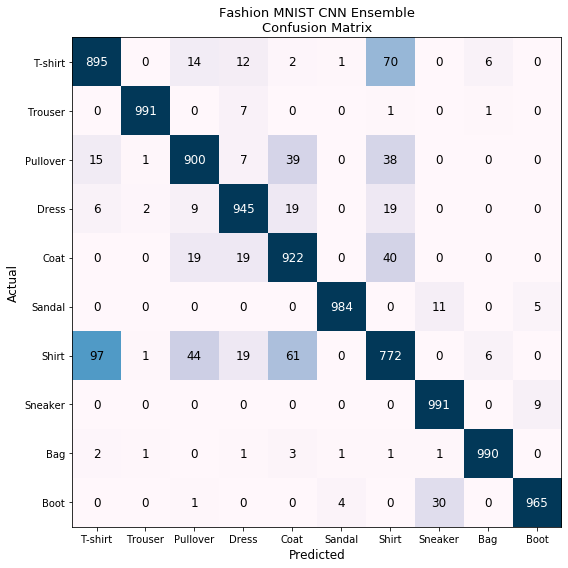

In [15]:
utils.plot_confusion(test_act, test_pred, dataset='fashion')

The confusion matrix above reveals poor performance of the model when classifying shirts, where items labelled `Shirt` are frequently misclassified as `T-shirt`, and vice versa. We also observe items labelled `Shirt` misclassified as `Coat` or `Pullover` at a high rate. Some other item pairs that are difficult for the model to tell apart are `Sneaker`/`Boot` and `Coat`/`Pullover`. Below, we display the first 50 misclassified fashion items from the testing data with their respective actual and predicted labels. For each label, we also display the probability that the label is true according to the trained ensemble. Doing this provides some insight into how close the CNN ensemble was to predicting the labels of misclassified items correctly.

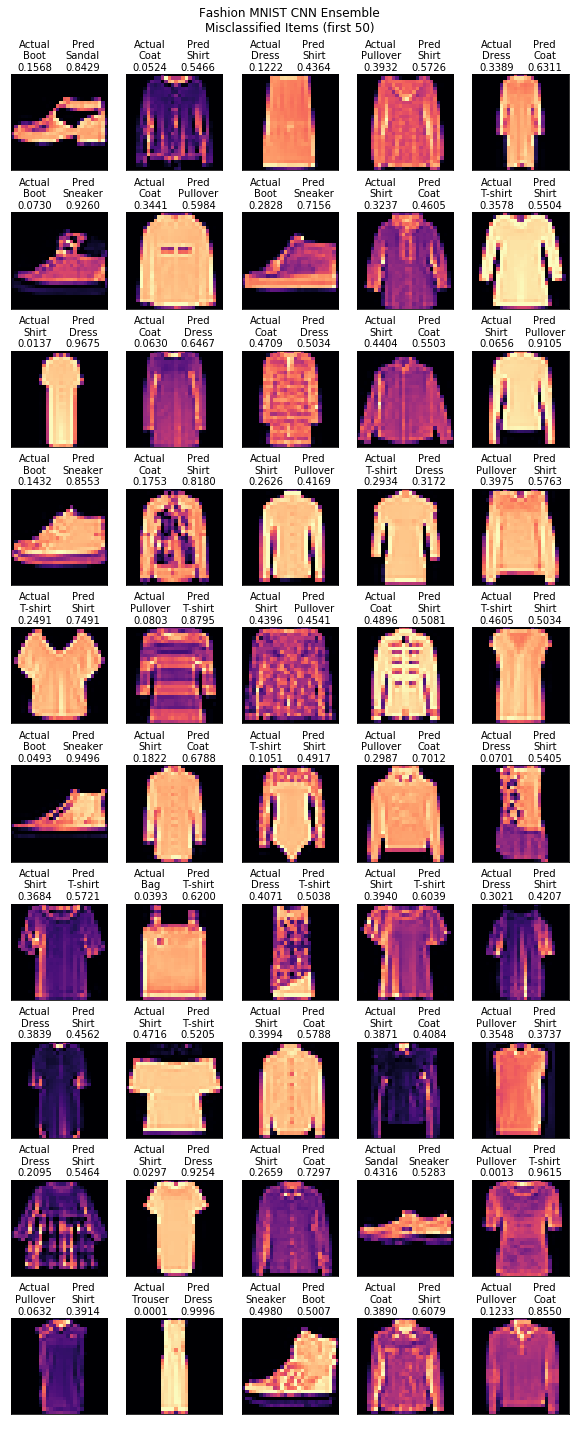

In [16]:
utils.plot_misclassified(x_test, test_pred, test_act, test_res,
                         dataset='fashion')